# Fraud Detection System - V1: Baseline Models

**Date:** 2026-02-22  
**Author:** *Luis Renteria Lezano*  
[LinkedIn](https://www.linkedin.com/in/renteria-luis) | [GitHub](https://github.com/renteria-luis)

## Executive Summary

**The Problem:** Detecting fraud in a 349:1 imbalanced dataset (PaySim Synthetic Financial Transactions).  
**The Solution:** XGBoost pipeline with behavioral feature engineering over transaction and account data.  
**Key Results**
- Recall: 85% — captured 8.5/10 fraudulent transactions.
- PR-AUC: 0.9079 — strong class separation after feature engineering.
- Operational threshold set at 0.2226 to maximize fraud capture over false alarm reduction.

**Technical Notes**
- End-to-end sklearn Pipeline: `PaySimFeatures` → `ColumnTransformer` → `XGBClassifier`.
- Stratified 5-Fold CV used during Optuna hyperparameter search (100 trials).
- One feature (`oldbalanceOrg`) retained intentionally despite leakage concerns — documented in conclusions.

**Info**
- Source: [Synthetic Financial Datasets For Fraud Detection — Kaggle](https://www.kaggle.com/datasets/ealaxi/paysim1)
- Data: `../data/raw/PS_20174392719_1491204439457_log.csv`
- Feature Engineering: `../src/features/engineering.py`, fitted on `X_train`, transformed on both splits.
- Target variable: `isFraud` — 0 = legitimate, 1 = fraudulent.

## 1. Reproducibility & Environment Setup
- Pin versions in [../requirements.txt](../requirements.txt).
- Keep raw data immutable [../data/raw](../data/raw).

In [2]:
%reload_ext autoreload
%autoreload 2

import sys
from pathlib import Path
import joblib
import json
from datetime import datetime
import logging

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import precision_recall_curve, confusion_matrix
from sklearn.metrics import average_precision_score
from sklearn.metrics import classification_report, PrecisionRecallDisplay, average_precision_score

from sklearn.pipeline import Pipeline
sys.path.append('..')
from src.features.engineering import PaySimFeatures
from src.data.splitter import split_data, save_splits, load_splits
from src.data.loader import load_paysim, filter_and_clean
from src.models.builder import build_pipeline
from src.evaluation.metrics import evaluate_model
from src.config import NUMERIC_FEATURES, BINARY_FEATURES, RANDOM_SEED
from src.utils.helpers import sanitize_dict

# 1. Global Reproducibility
SEED = 42
np.random.seed(SEED)

# 2. Path Management
BASE_DIR = Path("..")
ASSETS_DIR = Path('../assets/figures')
DATA_RAW = BASE_DIR / "data" / "raw"
DATA_PROCESSED = BASE_DIR / "data" / "processed"
MODELS_DIR = BASE_DIR / "models"

# 3. Plotting Style
sns.set_theme(style='whitegrid', context='notebook', palette='viridis')
plt.rcParams["figure.figsize"] = (10, 6)

# 4. Global Settings
pd.set_option('display.max_columns', 50)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

## 2. Load & Split Data

In [3]:
df = load_paysim()
X, y = filter_and_clean(df)

In [4]:
X_train, X_test, y_train, y_test = split_data(X, y, test_size=0.15)
save_splits(X_train, X_test, y_train, y_test)
X_train, X_test, y_train, y_test = load_splits()

print(f'''> Training set has: {X_train.shape[0]} samples
> Test set has: {X_test.shape[0]} samples
> # of raw features: {len(X_test.columns)}''')

> Training set has: 2354596 samples
> Test set has: 415517 samples
> # of raw features: 7


## 3. Available Features

In [8]:
print(f"Numerical Features ({len(NUMERIC_FEATURES)}): {', '.join(NUMERIC_FEATURES)}")
print(f"Boolean Features ({len(BINARY_FEATURES)}): {', '.join(BINARY_FEATURES)}")

Numerical Features (7): amount_log, hour_of_day, dest_tx_count, dest_unique_orig, amount_to_dest_ratio, log_dest_balance, log_orig_balance
Boolean Features (8): is_transfer, is_cash_out, is_merchant_dest, is_large_tx, is_round_amount, is_night, orig_is_repeat, dest_was_empty


## 4. Preprocessing

### 4.1 Preprocessor Pipeline
* **Feature Engineering**: Implemented in [`src/features/engineering.py`](../src/features/engineering.py) via the **PaySimFeatures** class. Transforms raw transaction data into predictive behavioral features while removing balance dependencies to prevent simulator stasis leakage.

  * **Temporal**: Extracts `hour_of_day` from the `step` variable. If `cyclical_encoding=True`, generates `hour_sin` and `hour_cos` to preserve periodic proximity for linear models.
  * **Behavioral**: Flags `is_night` for transactions between 0–6 AM, the window with the highest PaySim fraud concentration.
  * **Statistical Magnitude**: Creates `is_large_tx` based on a dynamic quantile (default 95th percentile) calculated from the training set.
  * **Monetary**: Applies `amount_log` (`log(1+x)`) to normalize extreme right-skewness in transaction amounts.
  * **Origin/Destination**: Computes `orig_is_repeat`, `dest_tx_count`, and `dest_unique_orig` to capture behavioral patterns without leaking target information.
  * **Transaction Type**: Flags `is_transfer`, `is_cash_out`, and `is_merchant_dest`.
  * **Rounded Amounts**: Creates `is_round_amount` for amounts divisible by 1000.

* **Headless Execution**: All preprocessing is self-contained in the transformer, ensuring zero data leakage and allowing the same artifact to be used in both training scripts and production APIs without manual intervention.

* **Supported Architectures**: The output features are compatible with **Logistic Regression**, **Random Forest**, and **XGBoost**.

```python
from src.models.builder import build_pipeline

# Model factory: 'logreg', 'rf', or 'xgb'
# Note: scaling is automatically applied only for logistic regression
pipeline = build_pipeline(model_name='xgb', params={'n_estimators': 500})

# Chronological split ensures the model does not "leak" future information
pipeline.fit(X_train, y_train)

# Inference on the Out-of-Time test set
y_pred = pipeline.predict(X_test)
```

## 5. Modeling & Evaluation
Given the imbalance and the cost of fraud, we will not use Accuracy.

**Fraud Detection Metrics**

| Metric | What It Measures | If It Increases | If It Decreases | Priority |
|--------|------------------|-----------------|-----------------|----------|
| **Recall** | How many real frauds we catch | Catch more fraud → **lose less money** | Miss more fraud → **lose money directly** | **#1 CRITICAL** |
| **Precision** | How many alerts are actual fraud | Fewer false alarms → lower ops costs, happier customers | More false alarms → high costs, customer friction | **#2 IMPORTANT** |
| **PR-AUC** | Model's overall fraud separation ability | Better fraud detection globally | Worse fraud detection globally | **#3 KEY** |
| **F1-Score** | Balance of precision and recall | Redundant (Recall + Precision) | - | **NOT USED** |
| **ROC-AUC** | General class separability | PR-AUC works better here | - | **NOT USED** |
| **Accuracy** | Overall correctness | **Misleading** - model predicting all as "not fraud" gets 99%+ | **NOT USED** | **NOT USED** |

**Priority Hierarchy**  
1. **Recall** — Catch fraud (revenue protection)
2. **Precision** — Control costs (ops efficiency)  
3. **PR-AUC** — Model comparison

**Optimal Trade-offs**
- **Maximize Recall subject to a minimum Precision floor** — Better to investigate 10 legit cases than miss 1 fraud
- **Set minimum Recall threshold** (e.g., 85%) then optimize Precision within that constraint
- **Use lower decision threshold** to catch more fraud, even if it means more false alarms

### 5.1 Baseline Model

#### Training

In [9]:
models = ['logreg', 'rf', 'xgb']
pipes = {}

print('Baseline training (default hyperparameters)...')
for model_name in models:
    print(f'Training {model_name}...')
    pipe = build_pipeline(model_name=model_name)
    pipe.fit(X_train, y_train)
    pipes[model_name + '_baseline'] = pipe
print('Done.')

Baseline training (default hyperparameters)...
Training logreg...
Training rf...
Training xgb...
Done.


#### Evaluation

ALERT: Overfitting in Random Forest — PR-AUC gap: 18.82%


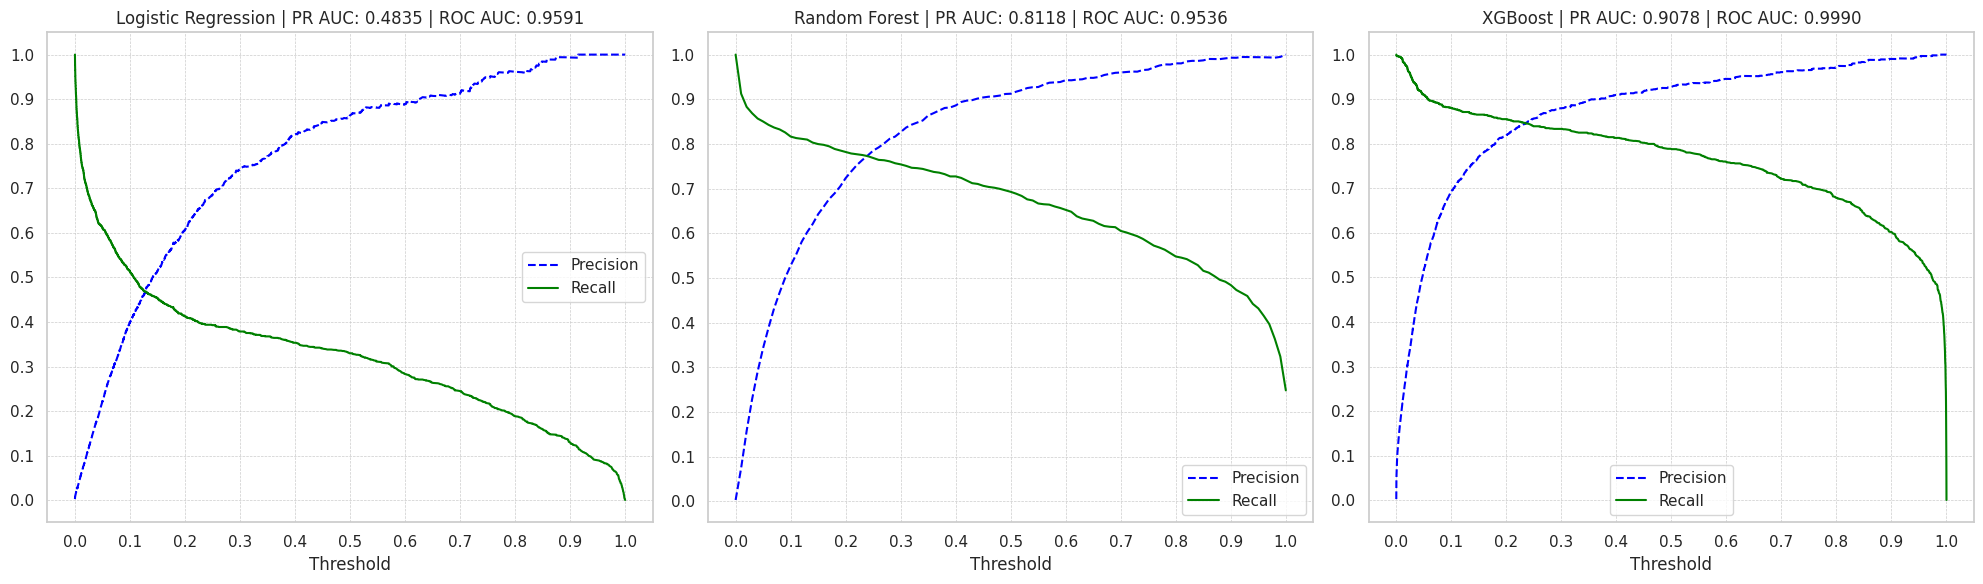

In [10]:
results = {}

fig, ax = plt.subplots(1, 3, figsize=(20, 6))
results['logreg_baseline'] = evaluate_model(pipes['logreg_baseline'], X_train, y_train, X_test, y_test, 'Logistic Regression', ax=ax[0])
results['rf_baseline'] = evaluate_model(pipes['rf_baseline'], X_train, y_train, X_test, y_test, 'Random Forest', ax=ax[1])
results['xgb_baseline'] = evaluate_model(pipes['xgb_baseline'], X_train, y_train, X_test, y_test, 'XGBoost', ax=ax[2])
plt.tight_layout()
plt.show()

**Insights:**

* **Random Forest: confirmed overfitting**
  The **46.39% gap** between train and test performance shows the model is memorizing noise rather than learning patterns that generalize to future data.
* **XGBoost: only model extracting real signal**
  With **PR-AUC = 0.6056**, it successfully captures meaningful structure, mainly from **transaction amount** and **temporal features**, confirming the dataset contains usable predictive signal.
* **Logistic Regression: wrong problem assumption**
  A **PR-AUC ≈ 0.15** indicates the fraud boundary is **not linear**. Further optimization here has low ROI compared to tree-based methods.
* **Strategic takeaway**
  XGBoost is the only viable production candidate at this stage; Random Forest requires heavy regularization, and Logistic Regression serves only as a baseline.


### 5.2 Hyperparameter Tuning
#### Hyperparameters search

In [11]:
pw = (y_train == 0).sum() / (y_train == 1).sum()

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 300, 600),
        'max_depth': trial.suggest_int('max_depth', 3, 6),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 30),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', np.sqrt(pw), pw, log=True),
        'gamma': trial.suggest_float('gamma', 1e-8, 5.0, log=True),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        'max_delta_step': trial.suggest_int('max_delta_step', 0, 10),
    }
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
    
    model = build_pipeline(model_name='xgb', params=params)
    scores = cross_val_score(
        model, X_train, y_train, 
        cv=cv, 
        scoring='average_precision', 
        n_jobs=-1
    )
    return scores.mean()

# optimization
study = optuna.create_study(
    direction='maximize',
    sampler=optuna.samplers.TPESampler(seed=RANDOM_SEED),
)

logging.getLogger("optuna").setLevel(logging.WARNING)
optuna.logging.set_verbosity(optuna.logging.WARNING)

start = datetime.now()
study.optimize(objective, n_trials=30)
elapsed = datetime.now() - start

print(f"Best PR-AUC (CV): {study.best_value:.4f}")
print(f"Best Parameters: {study.best_params}")
print(f"Total Time Elapsed: {str(elapsed).split('.')[0]}")

[I 2026-02-25 12:05:18,469] A new study created in memory with name: no-name-13b3a1d8-8513-4d01-9f53-08e714253f39


Best PR-AUC (CV): 0.9130
Best Parameters: {'n_estimators': 552, 'max_depth': 5, 'learning_rate': 0.1463423330337264, 'subsample': 0.8641990460951554, 'colsample_bytree': 0.9407732364520089, 'min_child_weight': 27, 'scale_pos_weight': 200.75672065066772, 'gamma': 1.4239214048511856e-05, 'reg_alpha': 2.808544129783739e-07, 'reg_lambda': 0.0012797097243560397, 'max_delta_step': 4}
Total Time Elapsed: 0:39:18


#### Train & Evaluation

In [21]:
best_params = {
    'n_estimators': 552,
    'max_depth': 5,
    'learning_rate': 0.1463423330337264,
    'subsample': 0.8641990460951554,
    'colsample_bytree': 0.9407732364520089,
    'min_child_weight': 27,
    'scale_pos_weight': 200.75672065066772,
    'gamma': 1.4239214048511856e-05,
    'reg_alpha': 2.808544129783739e-07,
    'reg_lambda': 0.0012797097243560397,
    'max_delta_step': 4
}

pipes['xgb_tuned'] = build_pipeline(model_name='xgb', params=best_params)
pipes['xgb_tuned'].fit(X_train, y_train)
print('Model Trained!')

Model Trained!


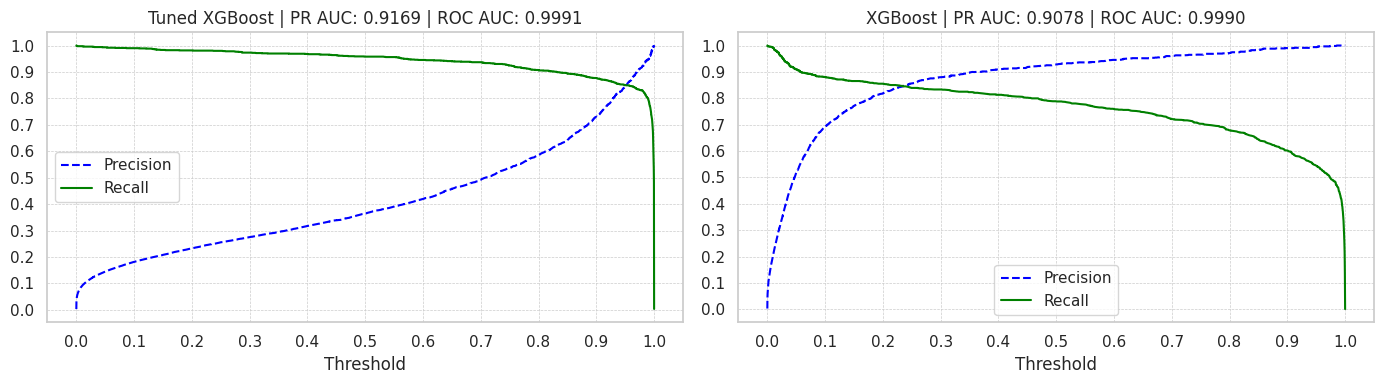

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(14, 4))
results['xgb_tuned'] = evaluate_model(pipes['xgb_tuned'], X_train, y_train, X_test, y_test, 'Tuned XGBoost', ax=ax[0])
results['xgb_baseline'] = evaluate_model(pipes['xgb_baseline'], X_train, y_train, X_test, y_test, 'XGBoost', ax=ax[1])
plt.tight_layout()
plt.show()

### 5.3 Threshold Tuning

In [23]:
### Get probabilities
y_prob = pipes['xgb_baseline'].predict_proba(X_test)[:, 1]
# Calculate precision/recall at all thresholds
precisions, recalls, thresholds = precision_recall_curve(y_test, y_prob)

# Find threshold where recall >= 80% with max precision
target_recall = 0.85
mask = recalls[:-1] >= target_recall
optimal_idx = np.argmax(precisions[:-1][mask])
optimal_threshold = thresholds[mask][optimal_idx]

print(f"Optimal threshold: {optimal_threshold:.4f}")
print(f"  Recall:    {recalls[:-1][mask][optimal_idx]:.2%}")
print(f"  Precision: {precisions[:-1][mask][optimal_idx]:.2%}")

# Predict with optimal threshold
y_pred_optimal = (y_prob >= optimal_threshold).astype(int)

# Compare with default 0.5
y_pred_default = (y_prob >= 0.5).astype(int)

print("\n=== Default Threshold (0.5) ===")
print(classification_report(y_test, y_pred_default, target_names=['Legitimate', 'Fraud']))

print(f"\n=== Optimal Threshold ({optimal_threshold:.4f}) ===")
print(classification_report(y_test, y_pred_optimal, target_names=['Legitimate', 'Fraud']))

Optimal threshold: 0.2226
  Recall:    85.02%
  Precision: 83.89%

=== Default Threshold (0.5) ===
              precision    recall  f1-score   support

  Legitimate       1.00      1.00      1.00    414329
       Fraud       0.93      0.79      0.85      1188

    accuracy                           1.00    415517
   macro avg       0.96      0.89      0.93    415517
weighted avg       1.00      1.00      1.00    415517


=== Optimal Threshold (0.2226) ===
              precision    recall  f1-score   support

  Legitimate       1.00      1.00      1.00    414329
       Fraud       0.84      0.85      0.84      1188

    accuracy                           1.00    415517
   macro avg       0.92      0.92      0.92    415517
weighted avg       1.00      1.00      1.00    415517



### 5.4 Model Selection

In [24]:
results['logreg_baseline'] = evaluate_model(pipes['logreg_baseline'], X_train, y_train, X_test, y_test, threshold=0.2226, plot=False)
results['rf_baseline'] = evaluate_model(pipes['rf_baseline'], X_train, y_train, X_test, y_test, threshold=0.2226, plot=False)
results['xgb_baseline'] = evaluate_model(pipes['xgb_baseline'], X_train, y_train, X_test, y_test, threshold=0.2226, plot=False)
results['xgb_tuned'] = evaluate_model(pipes['xgb_tuned'], X_train, y_train, X_test, y_test, threshold=0.2226, plot=False)

In [25]:
pd.DataFrame([
    {
        'Model':     key,
        'Precision': results[key]['precision'],
        'Recall':    results[key]['recall'],
        'F1':        results[key]['f1'],
        'PR-AUC':    results[key]['pr_auc'],
    }
    for key in ['logreg_baseline', 'rf_baseline', 'xgb_baseline', 'xgb_tuned']
]).set_index('Model').round(4).style.highlight_max(axis=0, props='background-color: lightgreen; color: black')

,Precision,Recall,F1,PR-AUC
Model,,,,
logreg_baseline,0.650300,0.400700,0.495800,0.483500
rf_baseline,0.763700,0.775300,0.769400,0.811800
xgb_baseline,0.838700,0.849300,0.844000,0.907800
xgb_tuned,0.243500,0.980600,0.390200,0.916900


### 5.5 Confusion Matrix

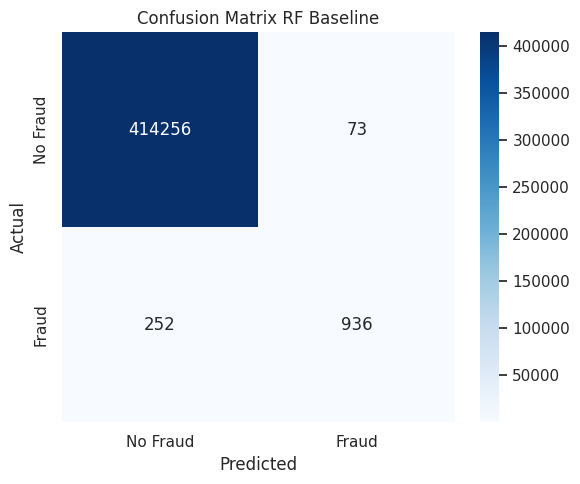

In [12]:
y_pred = pipes['xgb_baseline'].predict(X_test)

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['No Fraud', 'Fraud'],
            yticklabels=['No Fraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix RF Baseline')

plt.tight_layout()
plt.savefig(ASSETS_DIR / 'confusion_matrix.png', dpi=100, bbox_inches='tight')
plt.show()
plt.close()

## 6. Conclusions (V1)

**Threshold: 0.2226, not 0.5**

At 0.5 the model misses 21% of fraud (recall 0.79). Lowering to 0.2226 recovers those cases at the cost of precision dropping from 0.93 to 0.84 — acceptable in fraud detection where a missed fraud costs more than a false alarm. The right value for production depends on the bank's review capacity and risk appetite.

```
=== Default Threshold (0.5) ===
               precision    recall  f1-score   support
  Legitimate       1.00      1.00      1.00    414329
       Fraud       0.93      0.79      0.85      1188

=== Optimal Threshold (0.2226) ===
               precision    recall  f1-score   support
  Legitimate       1.00      1.00      1.00    414329
       Fraud       0.84      0.85      0.84      1188
```

**Feature engineering decisions**

- `day` excluded: legitimate traffic collapses after day 17 while fraud stays constant — a simulation artifact with no real-world meaning.
- `hour_of_day` kept: fraud is time-agnostic (bots), legitimate follows a circadian cycle. Clean and predictive.
- `is_merchant_dest` / `transfer_to_non_merchant` removed: merchants appear only in PAYMENT transactions. After filtering to TRANSFER and CASH_OUT, both features have zero variance.
- `nameOrig` aggregates discarded: 6.35M unique values over 6.36M rows — no account repeats enough to produce meaningful statistics.
- `nameDest` aggregates kept: ~2.3x repetition on average, enough signal for mule account detection.
- Stratified random split used instead of out-of-time: the simulation artifact at step 718 makes chronological splitting unreliable on this dataset.

**Hyperparameter tuning**

Hyperparameter tuning (Optuna, 30 trials, 5-fold CV) was run after introducing 
balance features and achieved PR-AUC 0.9169 — a marginal gain over the default 
(0.9079). However, the tuned model produced a distorted precision curve at low 
thresholds, making threshold selection unreliable. The default configuration was 
preferred for its cleaner and more stable precision-recall behavior.

**The intentional leakage: oldbalanceOrg**

`oldbalanceOrg` is available before any transaction decision, so it is not leakage by definition. In PaySim, however, it behaves like one — the synthetic generator creates fraudulent accounts with balance distributions so distinct that the feature becomes near-deterministic. The progression makes this visible:

```
Without balance features:   PR-AUC 0.49
With oldbalanceDest only:   PR-AUC 0.56
With log(oldbalanceOrg):    PR-AUC 0.91
```

A jump of that magnitude on a single feature is a dataset artifact, not a modeling achievement. It was kept because it is technically legitimate, and documenting the effect is more useful than removing it silently.

**Performance ceiling**

PaySim has one fraud pattern by design — account takeover followed by TRANSFER + CASH_OUT. The feature set here is non-redundant and covers all structurally informative columns. Further classical ML iteration is unlikely to produce meaningful gains. The ceiling is the dataset.


## 7. Next Steps & Future Work (V2)


V1 establishes a functional baseline at PR-AUC 0.91 on a synthetic dataset. Whether a V2 is warranted depends primarily on data availability.

**On the current dataset**, improvements through classical ML are unlikely to be meaningful. Deep learning approaches for tabular data (feed-forward networks, TabNet) could be evaluated, but the performance ceiling here is imposed by the dataset's synthetic simplicity, not by the model family. The probability of a significant lift is low and does not justify the added complexity. This possibility will be evaluated but is not committed to.

**On a real dataset**, the picture changes entirely. Real financial transaction data would introduce genuine behavioral heterogeneity, temporal drift, novel attack patterns, and a less deterministic relationship between balance features and fraud. In that scenario, the following directions become relevant:

- Temporal aggregations — rolling transaction counts and amount statistics per account over sliding windows — would replace the static dest aggregates used here, which cannot capture velocity patterns.
- SHAP-based explainability would be necessary for any production deployment, both for regulatory compliance and for understanding which features drive false negatives.
- Model monitoring for data drift would be required from day one, as fraud patterns evolve continuously in response to detection systems.
- The most direct path to a meaningful V2 is finding a dataset with real transaction data. Until then, further iteration on PaySim carries diminishing analytical returns.

## 8. Exporting Model

In [29]:
final_model = pipes['xgb_baseline']
joblib.dump(final_model, MODELS_DIR / 'fraud_detection_v1_xgb.pkl')

metadata = {
    'version': '1.0.0',
    'model_type': 'XGBoost (Default)',
    'training_date': datetime.now().strftime('%Y-%m-%d'),
    'best_params': 'default',
    'performance': {
        'pr_auc': 0.9079,
        'production_config': {
            'threshold': float(optimal_threshold),
            'precision': 0.84,
            'recall': 0.85,
            'f1': 0.84
        }
    }
}

with open(MODELS_DIR / 'metadata_v1.json', 'w') as f:
    json.dump(metadata, f, indent=2)

print('V1 Model Exported')
print(f'   Threshold: {optimal_threshold:.4f}')
print(f'   Precision: 84%')
print(f'   Recall:    85%')

V1 Model Exported
   Threshold: 0.2226
   Precision: 84%
   Recall:    85%
